# Import Library

In [ ]:
import tensorflow as tf  # Just for checking if GPU is available :)
GPU_AVAILABLE = tf.test.is_gpu_available()
print("GPU available:", GPU_AVAILABLE)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU available: False


In [ ]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile
from skimage import io
import numpy as np
import pandas as pd
import os
import skimage
import json
from skimage import transform
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import io, exposure, filters, transform
from skimage.filters import gaussian
from skimage.filters import roberts, sobel, prewitt
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
#Import the Keras API from Tensorflow
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D, Reshape,MaxPool2D, BatchNormalization, Dropout, InputLayer
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

# Required Functions

In [ ]:
def read(directory,folders_list):
  images = []
  Labels=[]
  images_df=pd.DataFrame()
  for folder in folders_list:
        folder_path = os.path.join(directory, folder)
        imgs = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
        for img in imgs:
          images.append(skimage.io.imread(img))
          Labels.append(folder)

  images_df['Features']=images
  images_df["Label"]=Labels
  return images_df

In [ ]:
def plot_images_per_class(images_df, images_per_class=4, columns=4):
    class_names = images_df["Label"].unique()
    fig, axes = plt.subplots(len(class_names), columns, figsize=(12, 12))

    for i, class_name in enumerate(class_names):
        class_images_df = images_df[images_df["Label"] == class_name].sample(images_per_class)
        class_images = class_images_df["Features"]

        for j in range(images_per_class):
            ax = axes[i, j]
            img = class_images.iloc[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(class_name)

    plt.tight_layout()
    plt.show()

In [ ]:
def train_valid_test_split(X, y, test_size, valid_size, random_seed):
    X_train_temp, X_valid_test, y_train_temp, y_valid_test = train_test_split(X, y, test_size=(valid_size + test_size), random_state=random_seed)

    X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test, y_valid_test,
                                                       test_size=test_size / (valid_size + test_size),
                                                       random_state=random_seed)

    return X_train_temp,y_train_temp, X_valid, y_valid, X_test, y_test


In [ ]:
def plotPieCharts(data_list, data_list_name):
    num_items = len(data_list)

    # Handle the case when there is only one item in the list
    if num_items == 1:
        fig, axes = plt.subplots(1, 1, figsize=(4, 6))
        labels_arraytype = data_list[0]
        class_labels, class_counts = np.unique(labels_arraytype, return_counts=True)

        pastel_palette = sns.color_palette('pastel', n_colors=len(class_labels))
        axes.pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=pastel_palette,
                    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
        axes.set_title(data_list_name[0])
    else:
        # Handle the case when there are multiple items in the list
        fig, axes = plt.subplots(1, num_items, figsize=(4 * num_items, 6))
        for i, labels_arraytype in enumerate(data_list):
            class_labels, class_counts = np.unique(labels_arraytype, return_counts=True)

            pastel_palette = sns.color_palette('pastel', n_colors=len(class_labels))
            axes[i].pie(class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90, colors=pastel_palette,
                        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
            axes[i].set_title(data_list_name[i])

    plt.tight_layout()
    plt.show()


In [ ]:
def resize_image(image, target_shape=(32, 32)):
    image_array = np.array(image)
    # Resize the image while preserving color channels
    resized_image = transform.resize(image_array, target_shape, anti_aliasing=True)
    return resized_image

In [ ]:
def model_accuracy(history):
    # dictionary keys seems to have changed in version 2
    k = ''
    if 'accuracy' in history.history :
        k = 'accuracy'

    if 'acc' in history.history :
        k = 'acc'

    if k != '' :
        plt.plot(history.history[k])
        plt.plot(history.history['val_'+k])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()


In [ ]:
def model_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



In [ ]:
def draw_confusion_matrices(y_true_train, y_pred_train, y_true_val, y_pred_val, y_true_test, y_pred_test, class_labels):
    # Calculate the confusion matrices and accuracy for training, validation, and testing sets
    train_confusion_matrix = confusion_matrix(y_train, y_train_predict)
    val_confusion_matrix = confusion_matrix(y_val, y_val_predict)
    test_confusion_matrix = confusion_matrix(y_test, y_test_predict)

    train_accuracy = accuracy_score(y_train, y_train_predict)
    val_accuracy = accuracy_score(y_val, y_val_predict)
    test_accuracy = accuracy_score(y_test, y_test_predict)

    # Plot confusion matrices
    plt.figure(figsize=(15, 5))
    plt.suptitle("Confusion Matrices and Accuracy")

    # Training Set
    plt.subplot(1, 3, 1)
    sns.heatmap(train_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Training Set\nAccuracy: {train_accuracy:.2f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Validation Set
    plt.subplot(1, 3, 2)
    sns.heatmap(val_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Validation Set\nAccuracy: {val_accuracy:.2f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Testing Set
    plt.subplot(1, 3, 3)
    sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Testing Set\nAccuracy: {test_accuracy:.2f}")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.tight_layout()
    plt.show()


In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels=['Common_Chickweed','Cleavers','Maize','Shepherds_Purse']):
    conf_mx = confusion_matrix(y_true, y_pred)

    # Create a heatmap of the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mx, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
def history_regression(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mean_absolute_error = history.history['mean_squared_error']
    val_mean_absolute_error = history.history['val_mean_squared_error']

    # Plot the loss curves for both height and width
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss ')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(mean_absolute_error, label='Training MSE')
    plt.plot(val_mean_absolute_error, label='Validation MSE')
    plt.legend()
    plt.title('Mean Squared Error (MSE)')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')

    plt.tight_layout()
    plt.show()


# 1. Getting Started

Open the .zip File

In [ ]:
file_name = "/content/drive/MyDrive/a3_dataset.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()

    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
a3_dataset/                                    2023-10-10 10:54:46            0
a3_dataset/img/                                2023-10-09 14:07:08            0
a3_dataset/img/Common_Chickweed/               2023-10-09 14:01:48            0
a3_dataset/img/Common_Chickweed/0.png          2019-10-15 08:40:32       338241
a3_dataset/img/Common_Chickweed/1.png          2019-10-15 08:40:30        79033
a3_dataset/img/Common_Chickweed/2.png          2019-10-15 08:40:28         9839
a3_dataset/img/Common_Chickweed/3.png          2019-10-15 08:40:26        17457
a3_dataset/img/Common_Chickweed/4.png          2019-10-15 08:40:34       372817
a3_dataset/img/Common_Chickweed/5.png          2019-10-15 08:40:32        10099
a3_dataset/img/Common_Chickweed/6.png          2019-10-15 08:40:32       131028
a3_dataset/img/Common_Chickweed/7.png          2019-10-15 08:40:32        15428
a3_dataset/img/Common_Chickweed/8.png   

In [ ]:
dataset_directory = '/content/a3_dataset/img'
folders_to_read = ['Common_Chickweed','Cleavers','Maize','Shepherds_Purse']

In [ ]:
#Call Function that Reads Images
dataset=read(dataset_directory,folders_to_read)

In [ ]:
#Check the length of the dataframe
len(dataset)

1000

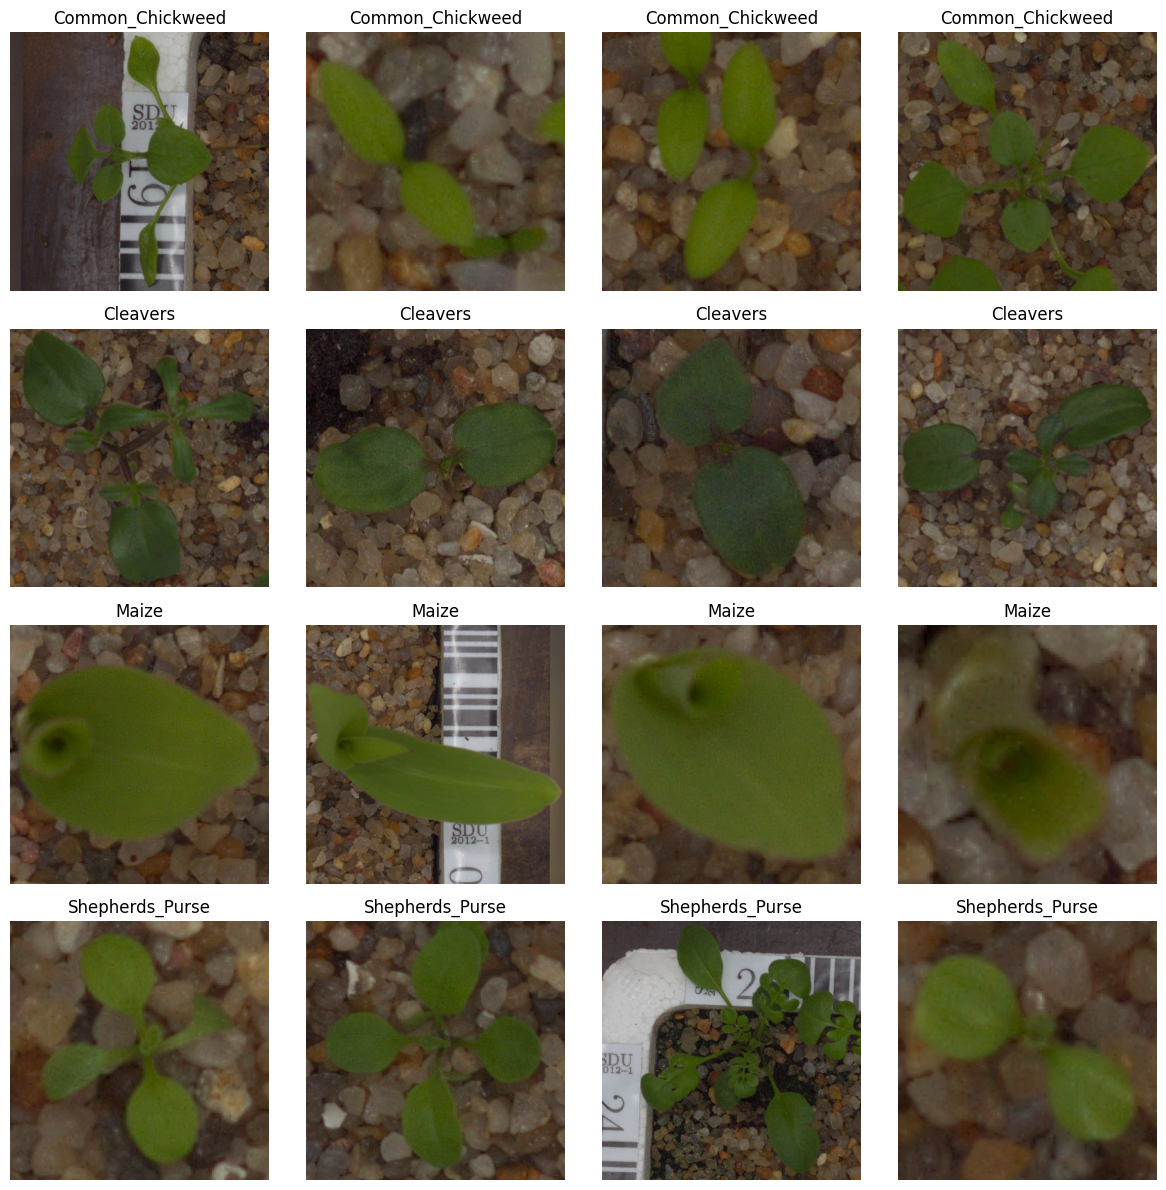

In [ ]:
#plot 4 Images From each Class
plot_images_per_class(dataset, images_per_class=4, columns=4)

In [ ]:
random_seed = 42

# Basic Transfer Learning

## 1- Classification Network

### a. Data Preparation

In [ ]:
X_train,y_train,X_val, y_val, X_test, y_test=train_valid_test_split(dataset["Features"],dataset["Label"], 0.15, 0.15, random_seed)


In [ ]:
# Print the sizes of the datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 700 samples
Validation set size: 150 samples
Test set size: 150 samples


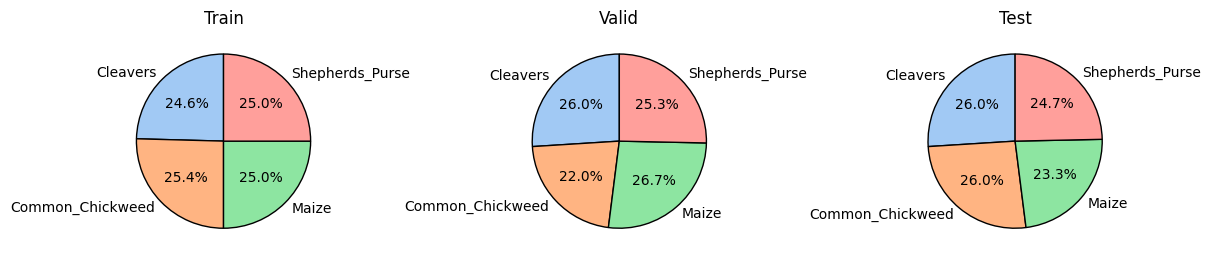

In [ ]:
data_list = [y_train, y_val,y_test]
data_list_name = ['Train', 'Valid','Test']
plotPieCharts(data_list,data_list_name)


For VGG net, we will need colour images of minimum size $32 \times 32$

In [ ]:
X_train = X_train.apply(resize_image)
X_val = X_val.apply(resize_image)
X_test = X_test.apply(resize_image)

In [ ]:
#Check Image Size
first_image = X_train[24]
image_shape = first_image.shape
print(f"Shape of the first image: {image_shape}")

Shape of the first image: (32, 32, 3)


In [ ]:
#Apply LabelEncoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.fit_transform(y_test)


Turn the numbers into one-hot vectors

In [ ]:
nClasses = 4
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_val_k = tensorflow.keras.utils.to_categorical(y_val, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test, num_classes=nClasses)


In [ ]:
y_train_k

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
X_train = np.stack(X_train.values)
X_train = X_train.astype('float32')

X_val = np.stack(X_val.values)
X_val = X_val.astype('float32')

X_test = np.stack(X_test.values)
X_test = X_test.astype('float32')

### b. Traing VGG-16
Import VGG net but with the first 6 layers only. we create our own version of a CNN network for the classification

In [ ]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

# Freeze the VGG-16 layers
for layer in vgg_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 2s 0us/step


Add new layers

In [ ]:
# last layers output
x = vgg_model.layers[6].output
x = Conv2D(256, (1, 1), activation='relu')(x)
x = Conv2D(256, (1, 1), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

# Create the modified model
vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
print(vgg_model_transfer.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
batchSize = 128
nEpochs = 50

opt = Adam(lr=0.001)
vgg_model_transfer.compile(loss='categorical_crossentropy',
                           optimizer=opt,
                           metrics=['accuracy'])


history = vgg_model_transfer.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1,
                                 validation_data=(X_test, y_test_k))


Epoch 1/50
6/6 [==============================] - 5s 661ms/step - loss: 5.3068 - accuracy: 0.2400 - val_loss: 1.6627 - val_accuracy: 0.2467
Epoch 2/50
6/6 [==============================] - 3s 578ms/step - loss: 1.5121 - accuracy: 0.2614 - val_loss: 1.3995 - val_accuracy: 0.2600
Epoch 3/50
6/6 [==============================] - 5s 819ms/step - loss: 1.3824 - accuracy: 0.2643 - val_loss: 1.3590 - val_accuracy: 0.2467
Epoch 4/50
6/6 [==============================] - 4s 697ms/step - loss: 1.3356 - accuracy: 0.2900 - val_loss: 1.3141 - val_accuracy: 0.4000
Epoch 5/50
6/6 [==============================] - 3s 589ms/step - loss: 1.2629 - accuracy: 0.4343 - val_loss: 1.2283 - val_accuracy: 0.3933
Epoch 6/50
6/6 [==============================] - 3s 573ms/step - loss: 1.1588 - accuracy: 0.5386 - val_loss: 1.0344 - val_accuracy: 0.6533
Epoch 7/50
6/6 [==============================] - 6s 1s/step - loss: 0.9887 - accuracy: 0.6057 - val_loss: 1.0327 - val_accuracy: 0.5600
Epoch 8/50
6/6 [=======

### c. Accuracy

In [ ]:
y_train_predict_prob = vgg_model_transfer.predict(X_train)
y_train_predict = y_train_predict_prob.argmax(axis=-1)

y_val_predict_prob = vgg_model_transfer.predict(X_val)
y_val_predict = y_val_predict_prob.argmax(axis=-1)

y_test_predict_prob = vgg_model_transfer.predict(X_test)
y_test_predict = y_test_predict_prob.argmax(axis=-1)

5/5 [==============================] - 1s 115ms/step


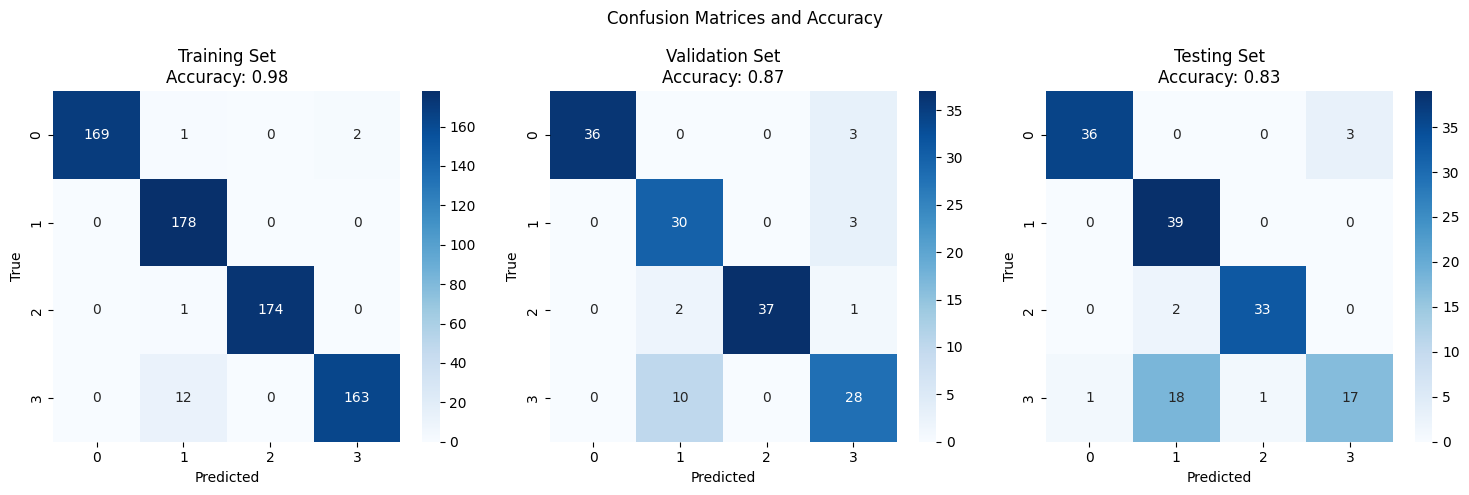

In [ ]:
draw_confusion_matrices(y_train, y_train_predict, y_val, y_val_predict, y_test, y_test_predict, folders_to_read)

### d. Training Validation History Visualization

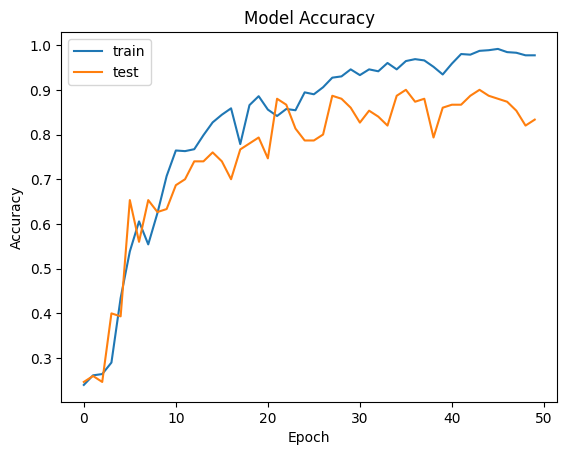

In [ ]:
model_accuracy(history)

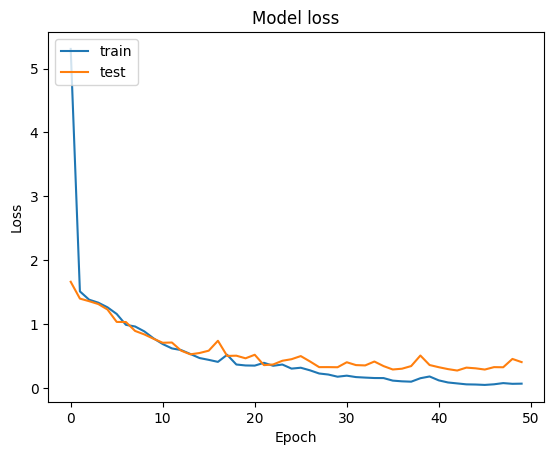

In [ ]:
model_loss(history)

In [ ]:
y_predict_prob = vgg_model_transfer.predict(X_val)
y_predict = y_predict_prob.argmax(axis=-1)

5/5 [==============================] - 1s 109ms/step


### e. Explanation

Explanation :


It appeares that overfitting is occurring because there is a noticeable increase in validation loss and a significant gap between training and validation accuracy. This is a common sign of overfitting.

Regarding the data size, it's possible that the small dataset is a contributing factor to the observed overfitting. When the training dataset is relatively small, neural networks can more easily memorize the training examples, leading to overfitting. .

I can observe from the learning curves:

**Training Loss vs. Validation Loss:** it seems that the training loss is consistently decreasing, while the validation loss decreases initially, but then starts to level off or increase slightly from around epoch 20 to 50. This suggests some potential overfitting as the model's performance on the validation set might not be improving.

**Training Accuracy vs. Validation Accuracy:** training accuracy continues to improve, while validation accuracy also improves but appears to stabilize after reaching a certain point (around epoch 30). The gap between training and validation accuracy isn't extremely large, but there is some difference, indicating a possible mild overfitting tendency.

## 2- Regression Network

### a. Data Preparation

Read JSON File for width and height Features

In [ ]:

from PIL import Image

# Define the path to the folder containing your image dataset
dataset_path = '/content/a3_dataset/img'

# Initialize lists to store image pixels, image names, and labels
image_data = []
image_names = []
labels = []

# Iterate through the subfolders (representing classes)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    # Iterate through the image files in each class folder
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)

        # Open and load the image using Pillow (PIL)
        image = Image.open(image_path)

        # Convert the image to a NumPy array (pixel data)
        image_array = np.array(image)

        # Append the image data, image name, and label to their respective lists
        image_data.append(image_array)
        image_names.append(image_file)
        labels.append(class_folder)  # Use the folder name as the label

# Create a DataFrame to store the data
data = pd.DataFrame({'image_name': image_names, 'feature': image_data, 'label': labels})

# Optionally, you can shuffle the DataFrame to randomize the order
data = data.sample(frac=1).reset_index(drop=True)

# Display the DataFrame




In [ ]:
import pandas as pd

# Assuming you have a DataFrame 'df'
# Extract and convert the numeric part of the "image name" and store it in a new column
data['image_number'] = data['image_name'].str.extract('(\d+)').astype(int)

# Remove the ".png" extension
data['image_name'] = data['image_name'].str.replace('.png', '')

# Drop the original "image_name" column if you no longer need it
data = data.drop(columns=['image_name'])




<ipython-input-22-89b6602ee1ac>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data['image_name'] = data['image_name'].str.replace('.png', '')


In [ ]:
data

,feature,label,image_number
0,"[[[54, 27, 18], [47, 21, 15], [56, 32, 27], [5...",Shepherds_Purse,170
1,"[[[45, 26, 17], [51, 32, 22], [57, 38, 26], [6...",Common_Chickweed,145
2,"[[[151, 155, 161], [150, 155, 160], [150, 154,...",Common_Chickweed,78
3,"[[[70, 59, 56], [68, 56, 54], [63, 50, 49], [6...",Maize,231
4,"[[[102, 80, 48], [105, 84, 52], [104, 83, 52],...",Shepherds_Purse,195
...,...,...,...
995,"[[[80, 59, 39], [80, 60, 40], [79, 60, 42], [7...",Cleavers,201
996,"[[[64, 39, 26], [63, 36, 24], [67, 40, 29], [6...",Cleavers,138
997,"[[[96, 78, 66], [100, 83, 71], [105, 87, 75], ...",Maize,38
998,"[[[99, 80, 63], [100, 81, 66], [82, 60, 45], [...",Maize,178


In [ ]:
import json
import pandas as pd

# Load the JSON file
with open("/content/a3_dataset/bbox.json", "r") as json_file:
    data1 = json.load(json_file)

# Initialize empty lists to store the flattened data
image_data = []

# Iterate through each class
for class_label, class_data in data1.items():
    for image_name, image_info in class_data.items():
        image_data.append({
            "image_name": image_name,
            "width": image_info["width"],
            "height": image_info["height"],
            "label": class_label
        })

# Create a DataFrame from the flattened data
df = pd.DataFrame(image_data)



In [ ]:
df

,image_name,width,height,label
0,0,426,457,Common_Chickweed
1,1,88,217,Common_Chickweed
2,2,40,63,Common_Chickweed
3,3,61,87,Common_Chickweed
4,4,237,472,Common_Chickweed
...,...,...,...,...
995,245,405,474,Shepherds_Purse
996,246,52,38,Shepherds_Purse
997,247,64,99,Shepherds_Purse
998,248,134,134,Shepherds_Purse


In [ ]:
import pandas as pd

# Assuming you have two DataFrames 'df1' and 'df2'
data['image_number'] = data['image_number'].astype(str)  # Convert image_number to string type

# Merge the DataFrames based on the 'label' and 'image number' columns
new_df = data.merge(df, left_on=['label', 'image_number'], right_on=['label', 'image_name'], how='inner')

# Drop the 'image_number' column since it's no longer needed
new_df = new_df.drop(columns=['image_number'])

# Rename the columns for clarity
new_df = new_df.rename(columns={'feature': 'image_feature'})

# Display the new DataFrame
print(new_df.head())


                                       image_feature             label  \
0  [[[54, 27, 18], [47, 21, 15], [56, 32, 27], [5...   Shepherds_Purse   
1  [[[45, 26, 17], [51, 32, 22], [57, 38, 26], [6...  Common_Chickweed   
2  [[[151, 155, 161], [150, 155, 160], [150, 154,...  Common_Chickweed   
3  [[[70, 59, 56], [68, 56, 54], [63, 50, 49], [6...             Maize   
4  [[[102, 80, 48], [105, 84, 52], [104, 83, 52],...   Shepherds_Purse   

  image_name  width  height  
0        170    351     270  
1        145     99     229  
2         78    117     219  
3        231    136     369  
4        195    337     476  


In [ ]:
max_height = max(new_df['height'])
max_width = max(new_df['width'])

# Normalize the height and width
new_df['Height_Normalized'] = new_df['height'] / max_height
new_df['Width_Normalized'] = new_df['width'] / max_width

### b. Regression using (Width and Height Labels)

In [ ]:
X_train,y_train,X_val, y_val, X_test, y_test=train_valid_test_split(new_df["image_feature"],new_df[["Height_Normalized", "Width_Normalized"]], 0.15, 0.15, random_seed)


In [ ]:
# Print the sizes of the datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 700 samples
Validation set size: 150 samples
Test set size: 150 samples


For VGG net, we will need colour images of minimum size $32 \times 32$

In [ ]:
X_train = X_train.apply(resize_image)
X_val = X_val.apply(resize_image)
X_test = X_test.apply(resize_image)

In [ ]:
#Check Image Size
first_image = X_train[24]
image_shape = first_image.shape
print(f"Shape of the first image: {image_shape}")

Shape of the first image: (32, 32, 3)


In [ ]:
X_train = np.stack(X_train.values)
X_train = X_train.astype('float32')

X_val = np.stack(X_val.values)
X_val = X_val.astype('float32')

X_test = np.stack(X_test.values)
X_test = X_test.astype('float32')

### c. Training VGG16

Add new layers

In [ ]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

# Freeze the VGG-16 layers
for layer in vgg_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# last layers output
x = vgg_model.layers[6].output
x = Conv2D(256, (1, 1), activation='relu')(x)
x = Conv2D(256, (1, 1), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
output_layer = Dense(2, activation='linear')(x)

# Create the regression model
regression_model = Model(inputs=vgg_model.input, outputs=output_layer)

In [ ]:
print(regression_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
batchSize = 128
nEpochs = 10


# Compile the model with an appropriate loss and metric for regression
regression_model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')



history = regression_model.fit(X_train, [y_train["Height_Normalized"],y_train["Width_Normalized"]], batch_size=batchSize, epochs=nEpochs, verbose=1,
                                 validation_data=(X_val, [y_val["Height_Normalized"],y_val["Width_Normalized"]]))


Epoch 1/10
6/6 [==============================] - 13s 2s/step - loss: 47.5948 - mean_squared_error: 47.5948 - val_loss: 16.7330 - val_mean_squared_error: 16.7330
Epoch 2/10
6/6 [==============================] - 7s 1s/step - loss: 5.3816 - mean_squared_error: 5.3816 - val_loss: 0.2205 - val_mean_squared_error: 0.2205
Epoch 3/10
6/6 [==============================] - 4s 640ms/step - loss: 0.2690 - mean_squared_error: 0.2690 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 4/10
6/6 [==============================] - 5s 802ms/step - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 5/10
6/6 [==============================] - 5s 832ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - val_loss: 0.0153 - val_mean_squared_error: 0.0153
Epoch 6/10
6/6 [==============================] - 4s 648ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0158 - val_mean_squared_error: 0.0158
Epoch 7/10
6/6 [=========================

### d. Training Validation History Visualization

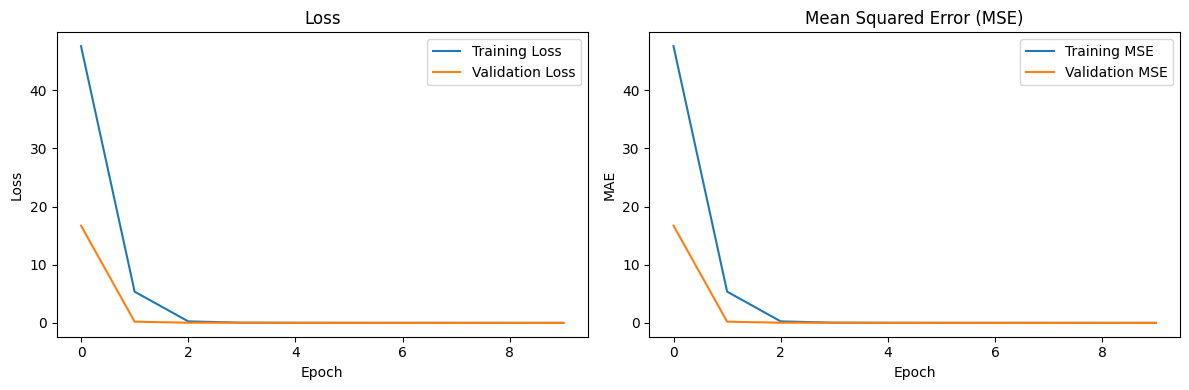

In [ ]:
history_regression(history)

### e. Mean Squared Error

In [ ]:
y_train_predict = regression_model.predict(X_train)

y_val_predict =  regression_model.predict(X_val)

y_test_predict = regression_model.predict(X_test)


5/5 [==============================] - 1s 181ms/step


In [ ]:
vgg_mean_squared_error_Height_Training = mean_squared_error(y_train["Height_Normalized"], y_train_predict[:,0])
vgg_mean_squared_error_Width_Training = mean_squared_error(y_train["Width_Normalized"], y_train_predict[:,1])
print("VGG16 Model Training mean_squared_error For Height: ",vgg_mean_squared_error_Height_Training)
print("VGG16 Model Training mean_squared_error For Width: ",vgg_mean_squared_error_Width_Training)
print("--------------------------------------------------------------------")

vgg_mean_squared_error_Height_val = mean_squared_error(y_val["Height_Normalized"], y_val_predict[:,0])
vgg_mean_squared_error_Width_val = mean_squared_error(y_val["Width_Normalized"], y_val_predict[:,1])
print("VGG16 Model Validation mean_squared_error For Height: ",vgg_mean_squared_error_Height_val)
print("VGG16 Model Validation mean_squared_error For Width: ",vgg_mean_squared_error_Width_val)
print("--------------------------------------------------------------------")

vgg_mean_squared_error_Height_Testing = mean_squared_error(y_test["Height_Normalized"], y_test_predict[:,0])
vgg_mean_squared_error_Width_Testing = mean_squared_error(y_test["Width_Normalized"], y_test_predict[:,1])
print("VGG16 Model Testing mean_squared_error For Height: ",vgg_mean_squared_error_Height_Testing )
print("VGG16 Model Testing mean_squared_error For Width: ",vgg_mean_squared_error_Width_Testing)
print("--------------------------------------------------------------------")

VGG16 Model Training mean_squared_error For Height:  0.011516109982580857
VGG16 Model Training mean_squared_error For Width:  0.011832810580418617
--------------------------------------------------------------------
VGG16 Model Validation mean_squared_error For Height:  0.009956151487819032
VGG16 Model Validation mean_squared_error For Width:  0.010930677475599155
--------------------------------------------------------------------
VGG16 Model Testing mean_squared_error For Height:  0.014438971179868873
VGG16 Model Testing mean_squared_error For Width:  0.01857607482511429
--------------------------------------------------------------------


### f. Explanation

**Training Loss (mean_squared_error)**: The training loss (mean squared error) consistently decreases throughout the epochs, which is a good sign. It indicates that the model is learning from the training data and improving its ability to make accurate predictions.

**Validation Loss (mean_squared_error)**: The validation loss (mean squared error) also consistently decreases throughout the epochs. This indicates that the model is generalizing well to the validation data.

it does not appear that overfitting is occurring in your regression CNN. Both the training and validation loss are decreasing and continue to decrease throughout the training process. This suggests that the model is learning the underlying patterns in the data and is not overfitting the training data.





## 3- Improving the Model

### a. Data Preparation

In [ ]:
X_train,y_train,X_val, y_val, X_test, y_test=train_valid_test_split(dataset["Features"],dataset["Label"], 0.15, 0.15, random_seed)


In [ ]:
# Print the sizes of the datasets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 700 samples
Validation set size: 150 samples
Test set size: 150 samples


For VGG net, we will need colour images of minimum size $32 \times 32$

In [ ]:
X_train = X_train.apply(resize_image)
X_val = X_val.apply(resize_image)
X_test = X_test.apply(resize_image)

In [ ]:
#Check Image Size
first_image = X_train[24]
image_shape = first_image.shape
print(f"Shape of the first image: {image_shape}")

Shape of the first image: (32, 32, 3)


In [ ]:
#Apply LabelEncoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.fit_transform(y_test)


Turn the numbers into one-hot vectors

In [ ]:
nClasses = 4
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_val_k = tensorflow.keras.utils.to_categorical(y_val, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test, num_classes=nClasses)


In [ ]:
y_train_k

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
X_train = np.stack(X_train.values)
X_train = X_train.astype('float32')

X_val = np.stack(X_val.values)
X_val = X_val.astype('float32')

X_test = np.stack(X_test.values)
X_test = X_test.astype('float32')

### b. Traing VGG-16
Import VGG net but with the first 6 layers only. we create our own version of a CNN network for the classification

In [ ]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

# Freeze the VGG-16 layers
for layer in vgg_model.layers:
    layer.trainable = False


Add new layers

In [ ]:
# last layers output
x = vgg_model.layers[6].output
x = Conv2D(256, (1, 1), activation='relu')(x)
x=BatchNormalization()(x) # To maintain the mean output close to 0 and the output standard deviation close to 1
x = Conv2D(256, (1, 1), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

## Fully connected hidden layer (using regularization and dropout to prevent overfitting)
x = Dense(4096, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
x=Dropout(0.3)(x)
x=Dropout(0.3)(x)
#x = BatchNormalization()(x)
x = Dense(4, activation='softmax')(x)

# Create the modified model
vgg_model_transfer = Model(inputs=vgg_model.input, outputs=x)

In [ ]:
print(vgg_model_transfer.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [ ]:
batchSize = 128
nEpochs = 50

opt = Adam(lr=0.001)
vgg_model_transfer.compile(loss='categorical_crossentropy',
                           optimizer=opt,
                           metrics=['accuracy'])


history = vgg_model_transfer.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1,
                                 validation_data=(X_test, y_test_k))


Epoch 1/50
6/6 [==============================] - 6s 642ms/step - loss: 1.8767 - accuracy: 0.3243 - val_loss: 3.5965 - val_accuracy: 0.2600
Epoch 2/50
6/6 [==============================] - 4s 598ms/step - loss: 1.5719 - accuracy: 0.5200 - val_loss: 6.9627 - val_accuracy: 0.2600
Epoch 3/50
6/6 [==============================] - 5s 817ms/step - loss: 1.2025 - accuracy: 0.6686 - val_loss: 9.1822 - val_accuracy: 0.2600
Epoch 4/50
6/6 [==============================] - 5s 701ms/step - loss: 0.9550 - accuracy: 0.7757 - val_loss: 11.8918 - val_accuracy: 0.2600
Epoch 5/50
6/6 [==============================] - 4s 605ms/step - loss: 0.7970 - accuracy: 0.8143 - val_loss: 10.6424 - val_accuracy: 0.2600
Epoch 6/50
6/6 [==============================] - 4s 598ms/step - loss: 0.6767 - accuracy: 0.8514 - val_loss: 10.1622 - val_accuracy: 0.2600
Epoch 7/50
6/6 [==============================] - 6s 994ms/step - loss: 0.5992 - accuracy: 0.8843 - val_loss: 10.9410 - val_accuracy: 0.2600
Epoch 8/50
6/6 [

### c. Training Validation History Visualization

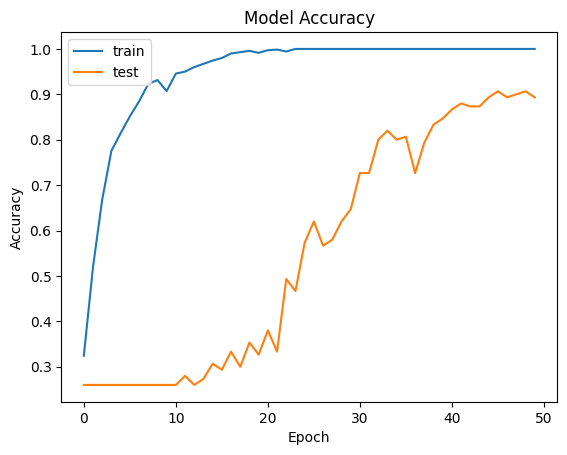

In [ ]:
model_accuracy(history)

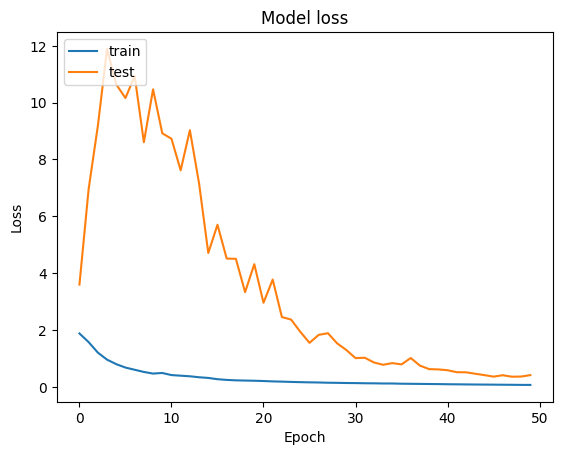

In [ ]:
model_loss(history)

In [ ]:
y_predict_prob = vgg_model_transfer.predict(X_val)
y_predict = y_predict_prob.argmax(axis=-1)

5/5 [==============================] - 1s 108ms/step


### d. Accuracy

In [ ]:
y_train_predict_prob = vgg_model_transfer.predict(X_train)
y_train_predict = y_train_predict_prob.argmax(axis=-1)

y_val_predict_prob = vgg_model_transfer.predict(X_val)
y_val_predict = y_val_predict_prob.argmax(axis=-1)

y_test_predict_prob = vgg_model_transfer.predict(X_test)
y_test_predict = y_test_predict_prob.argmax(axis=-1)

5/5 [==============================] - 1s 106ms/step


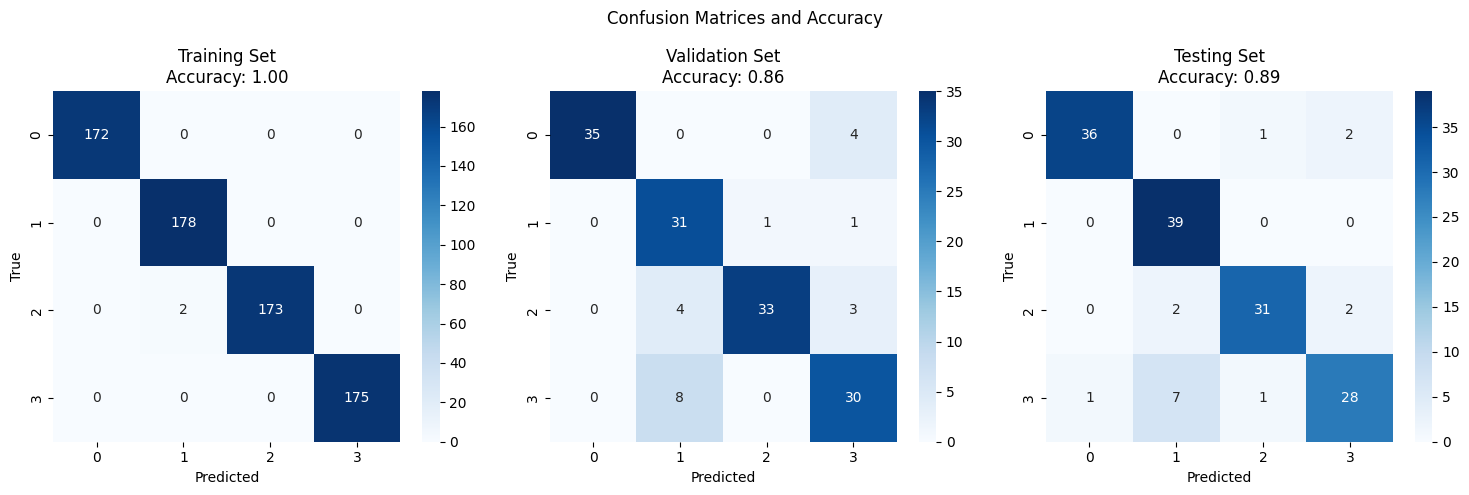

In [ ]:
draw_confusion_matrices(y_train, y_train_predict, y_val, y_val_predict, y_test, y_test_predict, folders_to_read)

In [ ]:
vgg_acc = accuracy_score(y_train, y_train_predict)
print("VGG16 Model Training Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

vgg_acc = accuracy_score(y_val, y_val_predict)
print("VGG16 Model Validation Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

vgg_acc = accuracy_score(y_test, y_test_predict)
print("VGG16 Model Testing Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Training Accuracy without Fine-Tuning: 99.71%
VGG16 Model Validation Accuracy without Fine-Tuning: 86.00%
VGG16 Model Testing Accuracy without Fine-Tuning: 89.33%


### f. EXplanation

The improvements observed:

1. **Loss Reduction**: In the base model, the loss decreases from 5.3068 to 0.4057, whereas the improved model reduces the loss from 1.8767 to 0.0657. This is a substantial reduction in loss, indicating that the improved model's predictions are much closer to the actual values.

2. **Accuracy Improvement**: The base model starts with an accuracy of 0.24 and increases to 0.83 after 50 epochs. On the other hand, the improved model starts with an accuracy of 0.32 and reaches a perfect accuracy of 1.0 after 50 epochs. This shows that the improved model performs significantly better in terms of accuracy.

3. **Overfitting Mitigation**: The base model experiences fluctuations in accuracy and loss, which could be indicative of overfitting, especially in the later epochs. In contrast, the improved model maintains a steady increase in accuracy and reduction in loss over the training period. This suggests that regularization techniques have helped mitigate overfitting.

4. **Validation Performance**: In the base model, the validation accuracy reaches a maximum of 0.8800, while in the improved model, the validation accuracy consistently increases to 0.9067. This demonstrates that the improved model generalizes better to the validation dataset.

The improved model shows a substantial improvement in terms of both loss reduction and accuracy increase. The regularization techniques applied have led to a more robust and accurate model, making it a better choice for making predictions and generalizing to new data.